# Topic Modeling
[Source with good interpretive visualization](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

[Better source to edit code](https://medium.com/@sayahfares19/text-analysis-topic-modelling-with-spacy-gensim-4cd92ef06e06) and [corresponding notebook](https://www.kaggle.com/code/faressayah/text-analysis-topic-modeling-with-spacy-gensim?scriptVersionId=119406980)

alternative: [BERTopic](https://maartengr.github.io/BERTopic/index.html)

**Topics don't make sense. What should I do about this?**
- Consider creating our own additional stop words and removing
- Could pre-process the text better using spacy. This would identify bigrams

**Incorporate topic modeling with lies/truth indicator. Assess how topics differ across lies and truths.**

In [41]:
# imports
import pandas as pd
import gensim
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# for visualizig LDA
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /Users/kenne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
# clean df so that speech_id is associated with each speech
speech_info = pd.read_csv('data-files/speech_info.csv')

# get video id and create dictionary to link
speech_info['Video ID'] = speech_info['YouTube Speech Link'].str.extract(r'v=([a-zA-Z0-9_-]+)')
vidID_to_speechID = dict(zip(speech_info['Video ID'], speech_info['Speech ID'],))

# get video id for transcripts
clip_transcripts = pd.read_csv('data-files/transcript_data_combined.csv')
clip_transcripts['Video ID'] = clip_transcripts['YouTube URL'].str.extract(r'youtu\.be/([a-zA-Z0-9_-]+)')

# replace video id with speech id and save to new column
clip_transcripts['Speech ID'] = clip_transcripts['Video ID'].replace(vidID_to_speechID).astype('int')

/var/folders/18/y5p3lwcd31j2dw1d0_k3lqsh0000gp/T/ipykernel_1353/2448508164.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clip_transcripts['Speech ID'] = clip_transcripts['Video ID'].replace(vidID_to_speechID).astype('int')


In [69]:
clip_transcripts

,YouTube URL,Chunk Number,Chunk Filename,Transcript,Video ID,Speech ID
0,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,1,/Users/milanvaghani/Desktop/Unstructed Machine...,NaN,-ofJu78Wpn0,1
1,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,2,/Users/milanvaghani/Desktop/Unstructed Machine...,good evening everyone. Good evening good even...,-ofJu78Wpn0,1
2,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,3,/Users/milanvaghani/Desktop/Unstructed Machine...,thank you thank you thank you thank you thank...,-ofJu78Wpn0,1
3,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,4,/Users/milanvaghani/Desktop/Unstructed Machine...,thank you all thank you all okay we got to g...,-ofJu78Wpn0,1
4,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,5,/Users/milanvaghani/Desktop/Unstructed Machine...,thank you everyone thank you everyone thank yo...,-ofJu78Wpn0,1
...,...,...,...,...,...,...
533,https://youtu.be/Q5TIZnhXX7Q?si=agpeKU04EQ-AtdJ_,177,/Users/milanvaghani/Desktop/Unstructed Machine...,the Liberty Bell it's where the Army whether i...,Q5TIZnhXX7Q,3
534,https://youtu.be/Q5TIZnhXX7Q?si=agpeKU04EQ-AtdJ_,178,/Users/milanvaghani/Desktop/Unstructed Machine...,this is the place where Pennsylvania Patriots ...,Q5TIZnhXX7Q,3
535,https://youtu.be/Q5TIZnhXX7Q?si=agpeKU04EQ-AtdJ_,179,/Users/milanvaghani/Desktop/Unstructed Machine...,come our way no matter what obstacles we must ...,Q5TIZnhXX7Q,3
536,https://youtu.be/Q5TIZnhXX7Q?si=agpeKU04EQ-AtdJ_,180,/Users/milanvaghani/Desktop/Unstructed Machine...,we will make America healthy again we will ma...,Q5TIZnhXX7Q,3


In [71]:
# inputs ---------------------------------------------------
num_topics = 10
filename = 'data-files/transcript_data_combined.csv' # should contain the 30 sec clip transcripts
# ----------------------------------------------------------

# Load your data
df = pd.read_csv(filename)

# Preprocessing: Tokenize and clean the text data
stop_words = set(stopwords.words('english'))

def preprocess(text):
    return [word for word in text.lower().split() if word not in stop_words]

# Apply preprocessing to the 'documents' column
processed_docs = df['Transcript'].dropna().apply(preprocess)

# Create a Gensim dictionary and corpus
dictionary = Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Train LDA model using Gensim
lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Create a DataFrame to store the topics and their words
topics_list = []

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")
    
for idx, topic in lda_model.print_topics(-1):
    # Clean and split the topic string into words
    topic_words = topic.replace('"', '').split(' + ')
    topic_words = [word.split('*')[1].strip() for word in topic_words]
    topics_list.append({'Topic': idx, 'Words': ', '.join(topic_words)})

# Convert the list to a DataFrame
topics_df = pd.DataFrame(topics_list)

# Display the DataFrame nicely
print(topics_df)


Topic 0: 0.016*"going" + 0.014*"country" + 0.010*"people" + 0.009*"we're" + 0.008*"said" + 0.008*"back" + 0.007*"come" + 0.007*"right" + 0.007*"know" + 0.007*"years"
Topic 1: 0.015*"great" + 0.011*"people" + 0.009*"know" + 0.009*"want" + 0.008*"going" + 0.008*"lot" + 0.008*"like" + 0.007*"we're" + 0.007*"got" + 0.007*"us"
Topic 2: 0.021*"going" + 0.009*"people" + 0.008*"country" + 0.007*"back" + 0.007*"said" + 0.007*"we're" + 0.007*"security" + 0.007*"america" + 0.006*"want" + 0.006*"think"
Topic 3: 0.019*"great" + 0.015*"people" + 0.013*"thank" + 0.012*"job" + 0.010*"said" + 0.010*"country" + 0.010*"much" + 0.009*"one" + 0.009*"say" + 0.008*"right"
Topic 4: 0.014*"going" + 0.011*"never" + 0.010*"got" + 0.009*"thank" + 0.009*"get" + 0.008*"know" + 0.008*"president" + 0.007*"would" + 0.007*"done" + 0.007*"we're"
Topic 5: 0.010*"good" + 0.010*"know" + 0.009*"he's" + 0.008*"people" + 0.008*"would" + 0.007*"country" + 0.007*"said" + 0.007*"one" + 0.006*"look" + 0.006*"get"
Topic 6: 0.011*"

In [72]:
# topic visualization
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.032764  0.037795       1        1  12.692664
1      0.030339  0.034408       2        1  12.659344
0      0.030840 -0.008996       3        1  11.858808
8     -0.001375 -0.054343       4        1  11.036987
2      0.044125  0.037579       5        1  10.532716
6      0.098886  0.035437       6        1   9.170655
4      0.030779  0.001566       7        1   9.139382
7      0.007269 -0.110571       8        1   8.130099
3     -0.111388  0.094470       9        1   7.577105
5     -0.096711 -0.067345      10        1   7.202240, topic_info=        Term        Freq       Total Category  logprob  loglift
4      thank  122.000000  122.000000  Default  30.0000  30.0000
965    great  127.000000  127.000000  Default  29.0000  29.0000
1034     job   35.000000   35.000000  Default  28.0000  28.0000
1075    he's   60.000000   60.000000  Default  27.0000  27.0000
257    never   66.000000   66.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
965    great    4.651300  127.710528  Topic10  -5.5111  -0.6818
24     right    4.377681   80.506515  Topic10  -5.5717  -0.2810
481    we're    4.310428   87.759907  Topic10  -5.5872  -0.3828
384   united    3.897922   36.860664  Topic10  -5.6878   0.3841
63       i'm    3.893596   37.214565  Topic10  -5.6889   0.3734

[752 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2696      4  0.913440    $5,000
3427      6  0.748737      $750
1588      7  0.623491       250
2628      4  0.137004         3
2628      5  0.548015         3
...     ...       ...       ...
302       3  0.267743     young
302       4  0.089248     young
302       6  0.178495     young
302      10  0.446238     young
858       5  0.613682  zelensky

[1730 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 2, 1, 9, 3, 7, 5, 8, 4, 6])

**Can I create an html with this visualization so we can insert it into our slideshow?**

In [33]:
s_index = list(df['Transcript'].dropna().index) # index must match index of original df
for topic_number in range(num_topics):
    topic_probs = [lda_model.get_document_topics(bow)[topic_number][1] for bow in corpus]
    topic_series = pd.Series(topic_probs, index=s_index)
    df[f"topic_{topic_number}_prob"] = topic_series

In [70]:
df

,YouTube URL,Chunk Number,Chunk Filename,Transcript,topic_0_series,topic_1_series,topic_0_prob,topic_1_prob
0,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,1,/Users/milanvaghani/Desktop/Unstructed Machine...,NaN,NaN,NaN,NaN,NaN
1,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,2,/Users/milanvaghani/Desktop/Unstructed Machine...,good evening everyone. Good evening good even...,0.948689,0.051303,0.948696,0.051306
2,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,3,/Users/milanvaghani/Desktop/Unstructed Machine...,thank you thank you thank you thank you thank...,0.930014,0.069978,0.930032,0.069994
3,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,4,/Users/milanvaghani/Desktop/Unstructed Machine...,thank you all thank you all okay we got to g...,0.972680,0.027322,0.972679,0.027319
4,https://youtu.be/-ofJu78Wpn0?si=H_BZ0KSYr_raPUac,5,/Users/milanvaghani/Desktop/Unstructed Machine...,thank you everyone thank you everyone thank yo...,0.907731,0.092270,0.907704,0.092273
...,...,...,...,...,...,...,...,...
533,https://youtu.be/Q5TIZnhXX7Q?si=agpeKU04EQ-AtdJ_,177,/Users/milanvaghani/Desktop/Unstructed Machine...,the Liberty Bell it's where the Army whether i...,0.721423,0.278591,0.721417,0.278580
534,https://youtu.be/Q5TIZnhXX7Q?si=agpeKU04EQ-AtdJ_,178,/Users/milanvaghani/Desktop/Unstructed Machine...,this is the place where Pennsylvania Patriots ...,0.979123,0.020867,0.979123,0.020869
535,https://youtu.be/Q5TIZnhXX7Q?si=agpeKU04EQ-AtdJ_,179,/Users/milanvaghani/Desktop/Unstructed Machine...,come our way no matter what obstacles we must ...,0.016755,0.983245,0.016747,0.983254
536,https://youtu.be/Q5TIZnhXX7Q?si=agpeKU04EQ-AtdJ_,180,/Users/milanvaghani/Desktop/Unstructed Machine...,we will make America healthy again we will ma...,0.031742,0.968256,0.031741,0.968260


## Additional issues

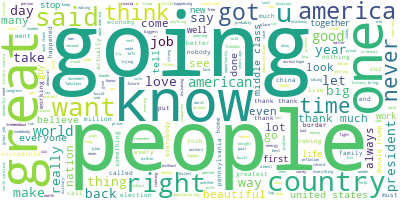

In [29]:
# consider additional stop words based on word cloud
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ' '.join(processed_docs.map(lambda x: ' '.join(x)))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()